# FashionMNIST时装分类
![](https://datawhalechina.github.io/thorough-pytorch/_images/fashion-mnist-sprite.png)

我们这里的任务是对10个类别的“时装”图像进行分类，使用FashionMNIST数据集。 上图给出了FashionMNIST中数据的若干样例图，其中每个小图对应一个样本。
FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。每张图像均为单通道黑白图像，大小为28*28pixel，分属10个类别。
### 导包

In [25]:
import os 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

### 配置环境训练和超参数

In [61]:
# 配置GPU，这里有两种方式
## 方案一：使用os.environ
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 0   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

### 数据读入和加载
这里同时展示两种方式:

下载并使用PyTorch提供的内置数据集

从网站下载以csv格式存储的数据，读入并转成预期的格式
第一种数据读入方式只适用于常见的数据集，如MNIST，CIFAR10等，PyTorch官方提供了数据下载。这种方式往往适用于快速测试方法（比如测试下某个idea在MNIST数据集上是否有效）
第二种数据读入方式需要自己构建Dataset，这对于PyTorch应用于自己的工作中十分重要

同时，还需要对数据进行必要的变换，比如说需要将图片统一为一致的大小，以便后续能够输入网络训练；需要将数据格式转为Tensor类，等等。

这些变换可以很方便地借助torchvision包来完成，这是PyTorch官方用于图像处理的工具库，上面提到的使用内置数据集的方式也要用到。PyTorch的一大方便之处就在于它是一整套“生态”，有着官方和第三方各个领域的支持。这些内容我们会在后续课程中详细介绍。

In [100]:
# 首先设置数据换
from torchvision import transforms

image_size = 28 
data_transform = transforms.Compose([
#     transforms.ToPILImage(),
    # 这一步取决于后续的数据读取方式，如果使用内置数据集读取方式则不需要
    transforms.ToTensor(),
    transforms.Resize(image_size)
    
])

In [105]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据

In [106]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

可视化

torch.Size([256, 1, 28, 28]) torch.Size([256])


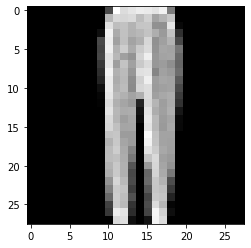

In [107]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

### 模型设计
由于任务较为简单，这里我们手搭一个CNN，而不考虑当下各种模型的复杂结构，模型构建完成后，将模型放到GPU上用于训练。

In [117]:
# 张图像均为单通道黑白图像，大小为28*28pixel，分属10个类别。
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    
    def forward(self,x):
        x = self.conv(x)
        x = x.view(-1,64*4*4)
        x = self.fc(x)
        # x = nn.funtional.normalize(x)
        return x
    
model = Net()
# model = model.cuda()

### 设定损失函数
使用torch.nn模块自带的CrossEntropy损失
PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss
这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑

In [118]:
criterion = nn.CrossEntropyLoss()

In [119]:
# # 这里方便看一下weighting等策略
?nn.CrossEntropyLoss 

### 设定优化器

In [120]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 训练和测试（验证）
各自封装成函数，方便后续调用
关注两者的主要区别：

- 模型状态设置

- 是否需要初始化优化器

- 是否需要将loss传回到网络

- 是否需要每步更新optimizer

此外，对于测试或验证过程，可以计算分类准确率

In [121]:
# 训练过程
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
#         data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
# 测试过程    
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
#           data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [123]:
if __name__ == '__main__' : 
# 主函数
    for epoch in range(1, epochs+1):
        print("第"+str(epoch)+"轮训练与测试：")
        train(epoch)
        val(epoch)

第1轮训练与测试：
Epoch: 1 	Training Loss: 0.174166
Epoch: 1 	Validation Loss: 0.220920, Accuracy: 0.918800
第2轮训练与测试：
Epoch: 2 	Training Loss: 0.169405
Epoch: 2 	Validation Loss: 0.223340, Accuracy: 0.919600
第3轮训练与测试：
Epoch: 3 	Training Loss: 0.162666
Epoch: 3 	Validation Loss: 0.223142, Accuracy: 0.922900
第4轮训练与测试：
Epoch: 4 	Training Loss: 0.157157
Epoch: 4 	Validation Loss: 0.232861, Accuracy: 0.916400
第5轮训练与测试：
Epoch: 5 	Training Loss: 0.156765
Epoch: 5 	Validation Loss: 0.220231, Accuracy: 0.925900
第6轮训练与测试：
Epoch: 6 	Training Loss: 0.154458
Epoch: 6 	Validation Loss: 0.225280, Accuracy: 0.922000
第7轮训练与测试：
Epoch: 7 	Training Loss: 0.144363
Epoch: 7 	Validation Loss: 0.227795, Accuracy: 0.920100
第8轮训练与测试：
Epoch: 8 	Training Loss: 0.145523
Epoch: 8 	Validation Loss: 0.234561, Accuracy: 0.919100
第9轮训练与测试：
Epoch: 9 	Training Loss: 0.138404
Epoch: 9 	Validation Loss: 0.235604, Accuracy: 0.919600
第10轮训练与测试：
Epoch: 10 	Training Loss: 0.137579
Epoch: 10 	Validation Loss: 0.227419, Accuracy: 0.9215